In [1]:

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
sys.path.append(os.path.abspath("../lib"))
from all import all_in_one

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_dpe.csv", "name": "dpe", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
dpe = dataframes['dpe'].filter(F.col("heating_emission").cast("int").isNotNull()).withColumn('heating_emission', F.col('heating_emission').cast('int'))
dpe_training = dpe.drop('GES_emission').filter(F.col('DPE_consumption') < 700)
ges_training = dpe.drop('DPE_consumption').filter(F.col('GES_emission') < 200)
dictionary = dataframes['dictionary']

In [5]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# linear
from sklearn.linear_model import Ridge

# random forest
from sklearn.ensemble import RandomForestRegressor

# XGboost
from xgboost.sklearn import XGBRegressor

# quickXGboost
from sklearn.ensemble import HistGradientBoostingRegressor

#hyperparams
from scipy.stats import uniform, randint

# DPE

0.383631083885393 {'alpha': 32}
0.3886241008029361 {'max_depth': 4, 'n_estimators': 113}
0.4100347252827116 {'l2_regularization': 0.9632366534401319, 'learning_rate': 0.039390694124254874, 'max_iter': 120}
not handled for this type of algorithm


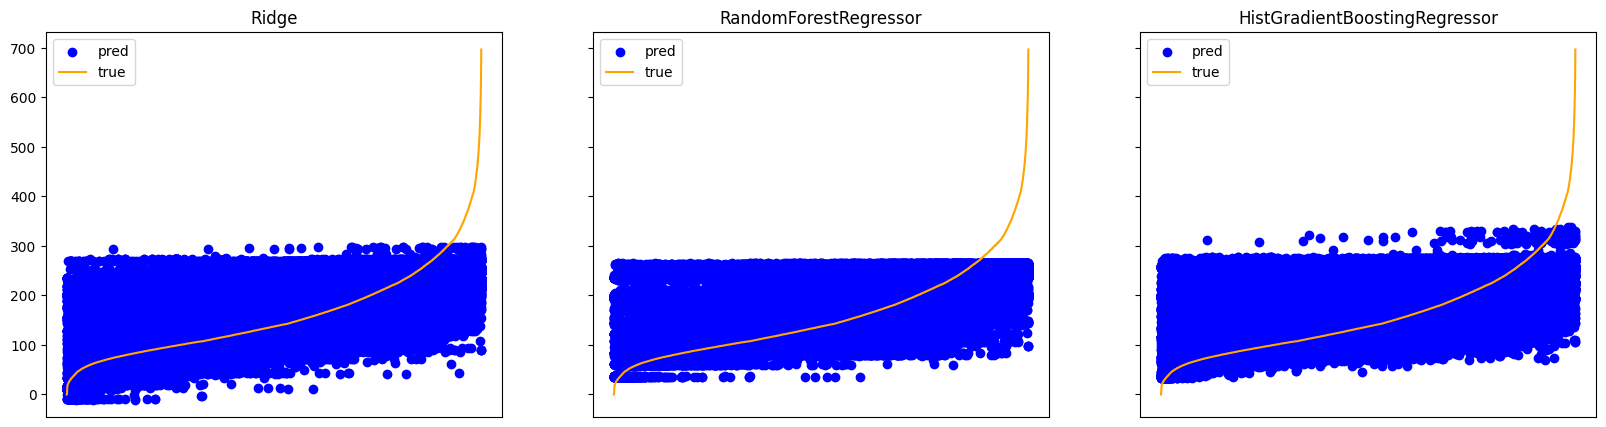

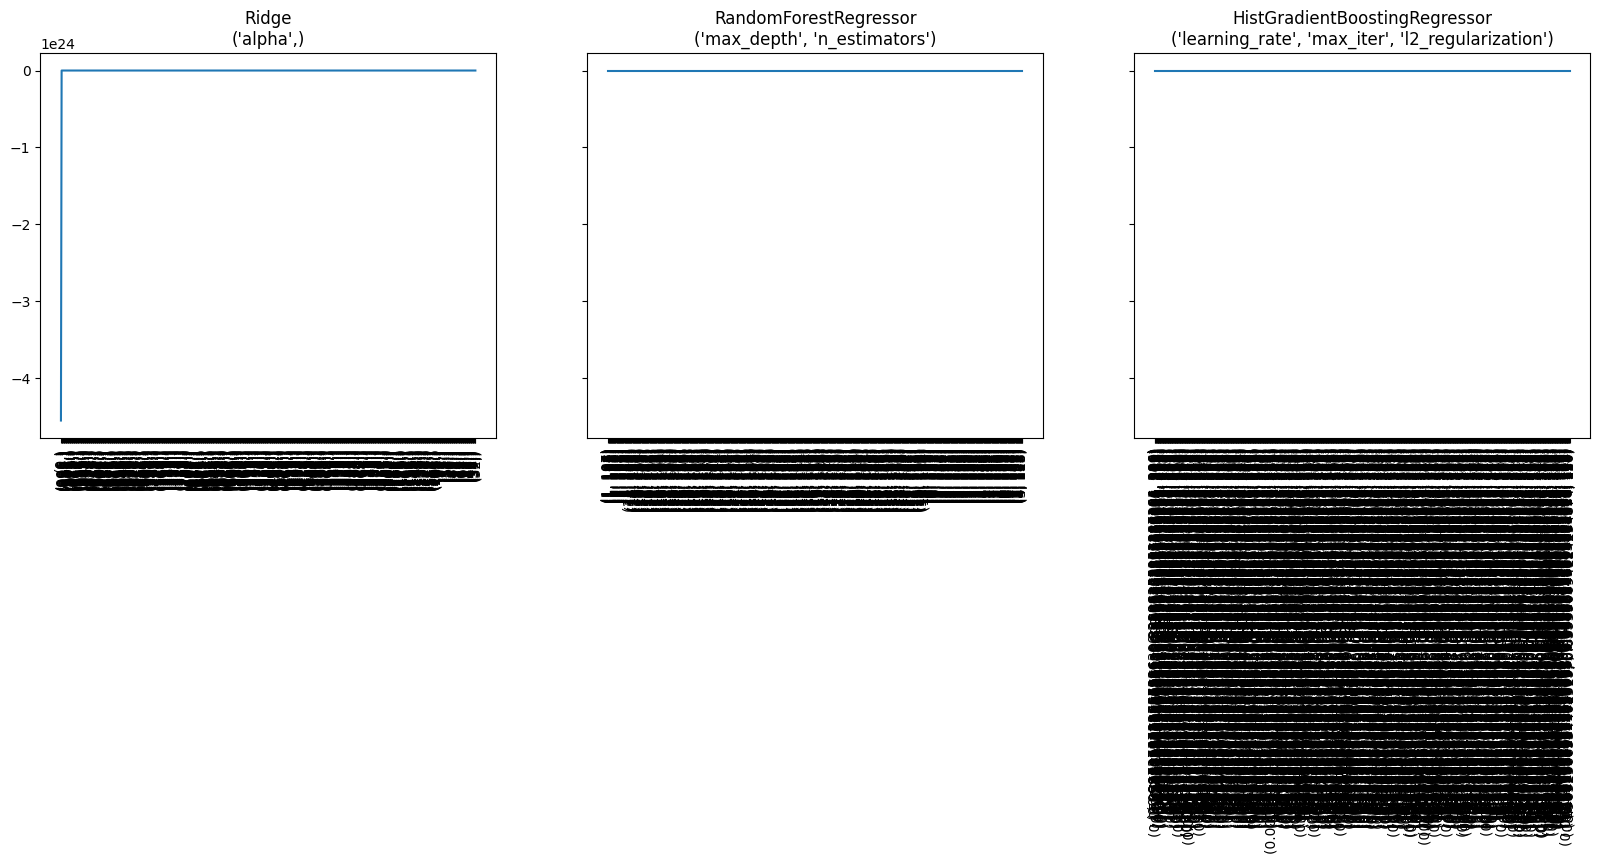

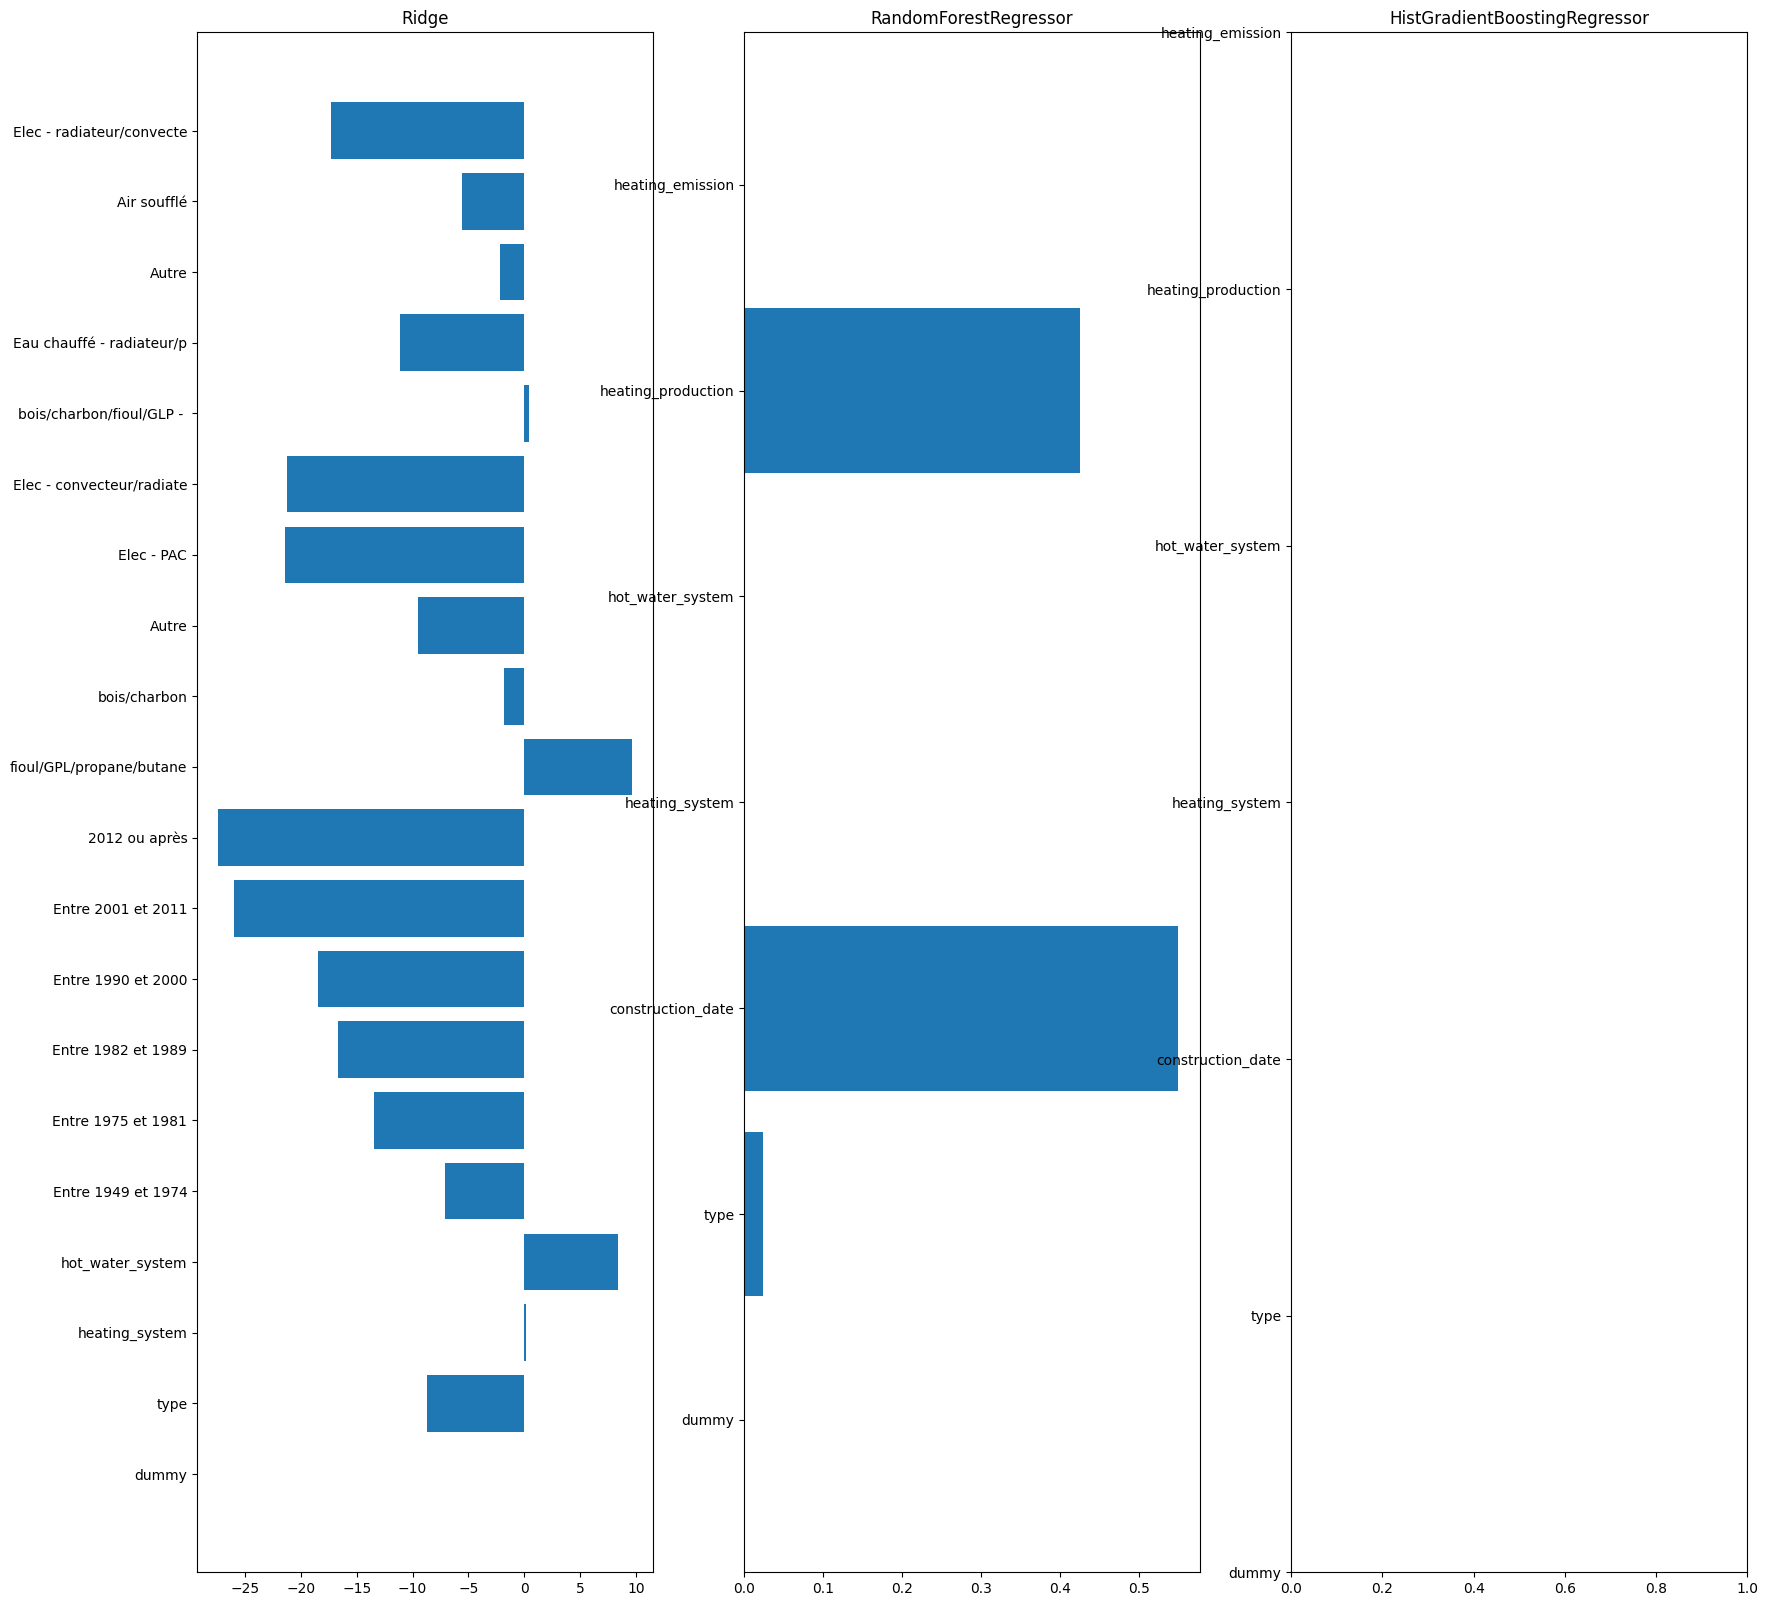

In [6]:
col_X_hot = [['construction_date', 'heating_production', 'heating_emission'],
            [],
            []]
col_y = ['DPE_consumption']
col_X_not_hot = [[col[0] for col in dpe_training.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

categorical_features = [i for i in range(6)]

hyperparams_models = [
    {
        'alpha': randint(0,1000),
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'max_iter' : randint(100,300),
        'l2_regularization' : uniform(0,1),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'Ridge': Ridge,
    'RandomForestRegressor': RandomForestRegressor,
    'HistGradientBoostingRegressor' : HistGradientBoostingRegressor,
}
best_models_dpe = all_in_one(dpe_training, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4, verbose=0)

# GES 

0.5980428976543779 {'alpha': 13}
0.6251132710332482 {'max_depth': 5, 'n_estimators': 155}
0.6330882585872029 {'l2_regularization': 0.11976213181925122, 'learning_rate': 0.2971581842219685, 'max_iter': 124}
not handled for this type of algorithm


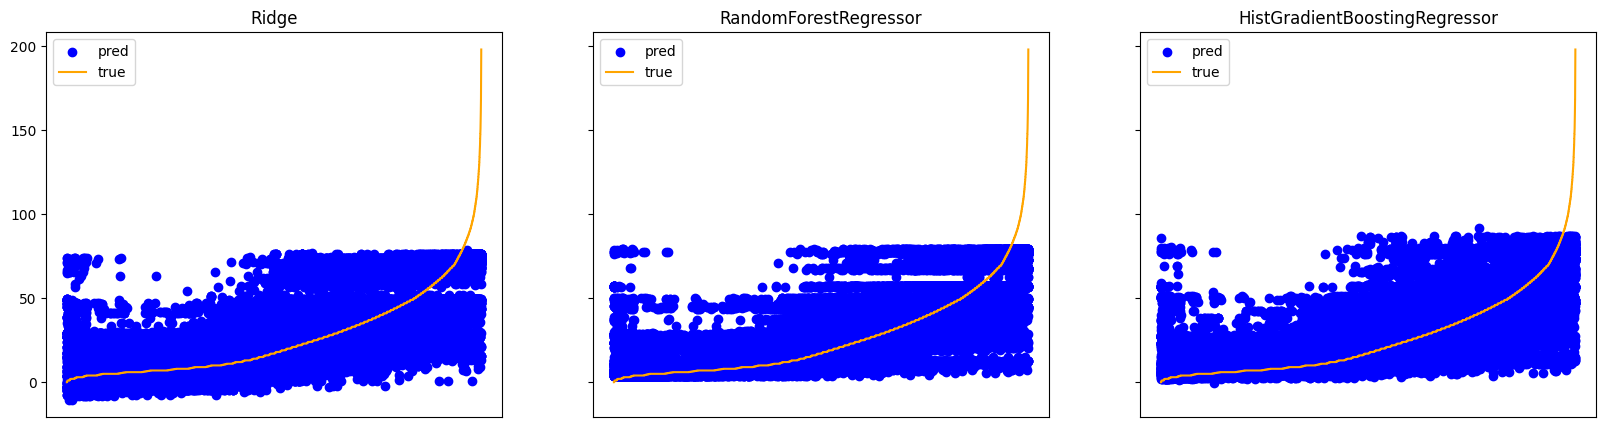

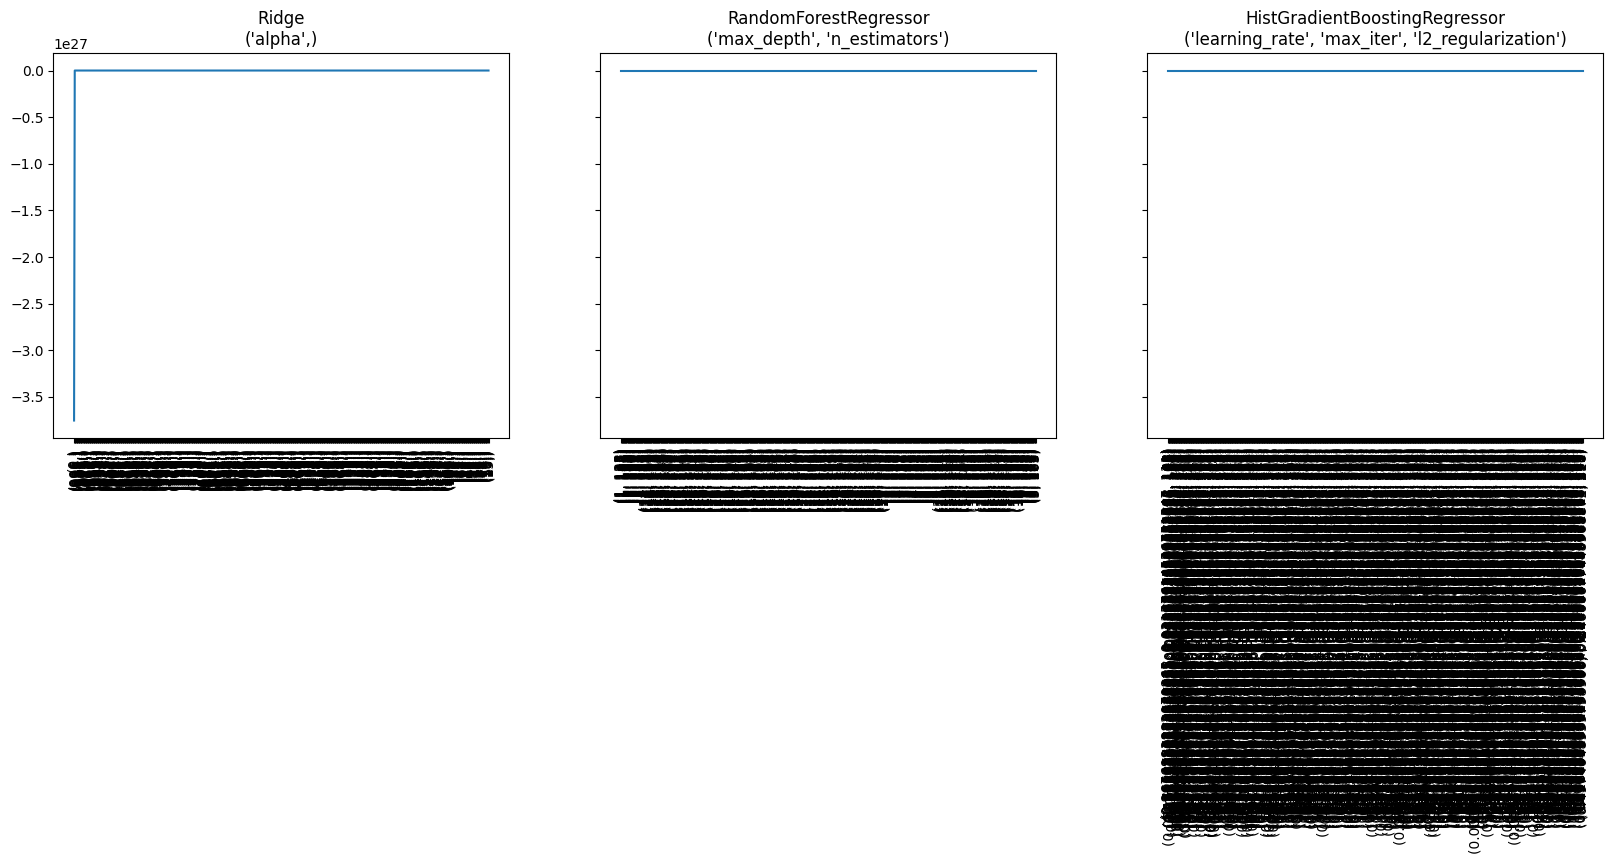

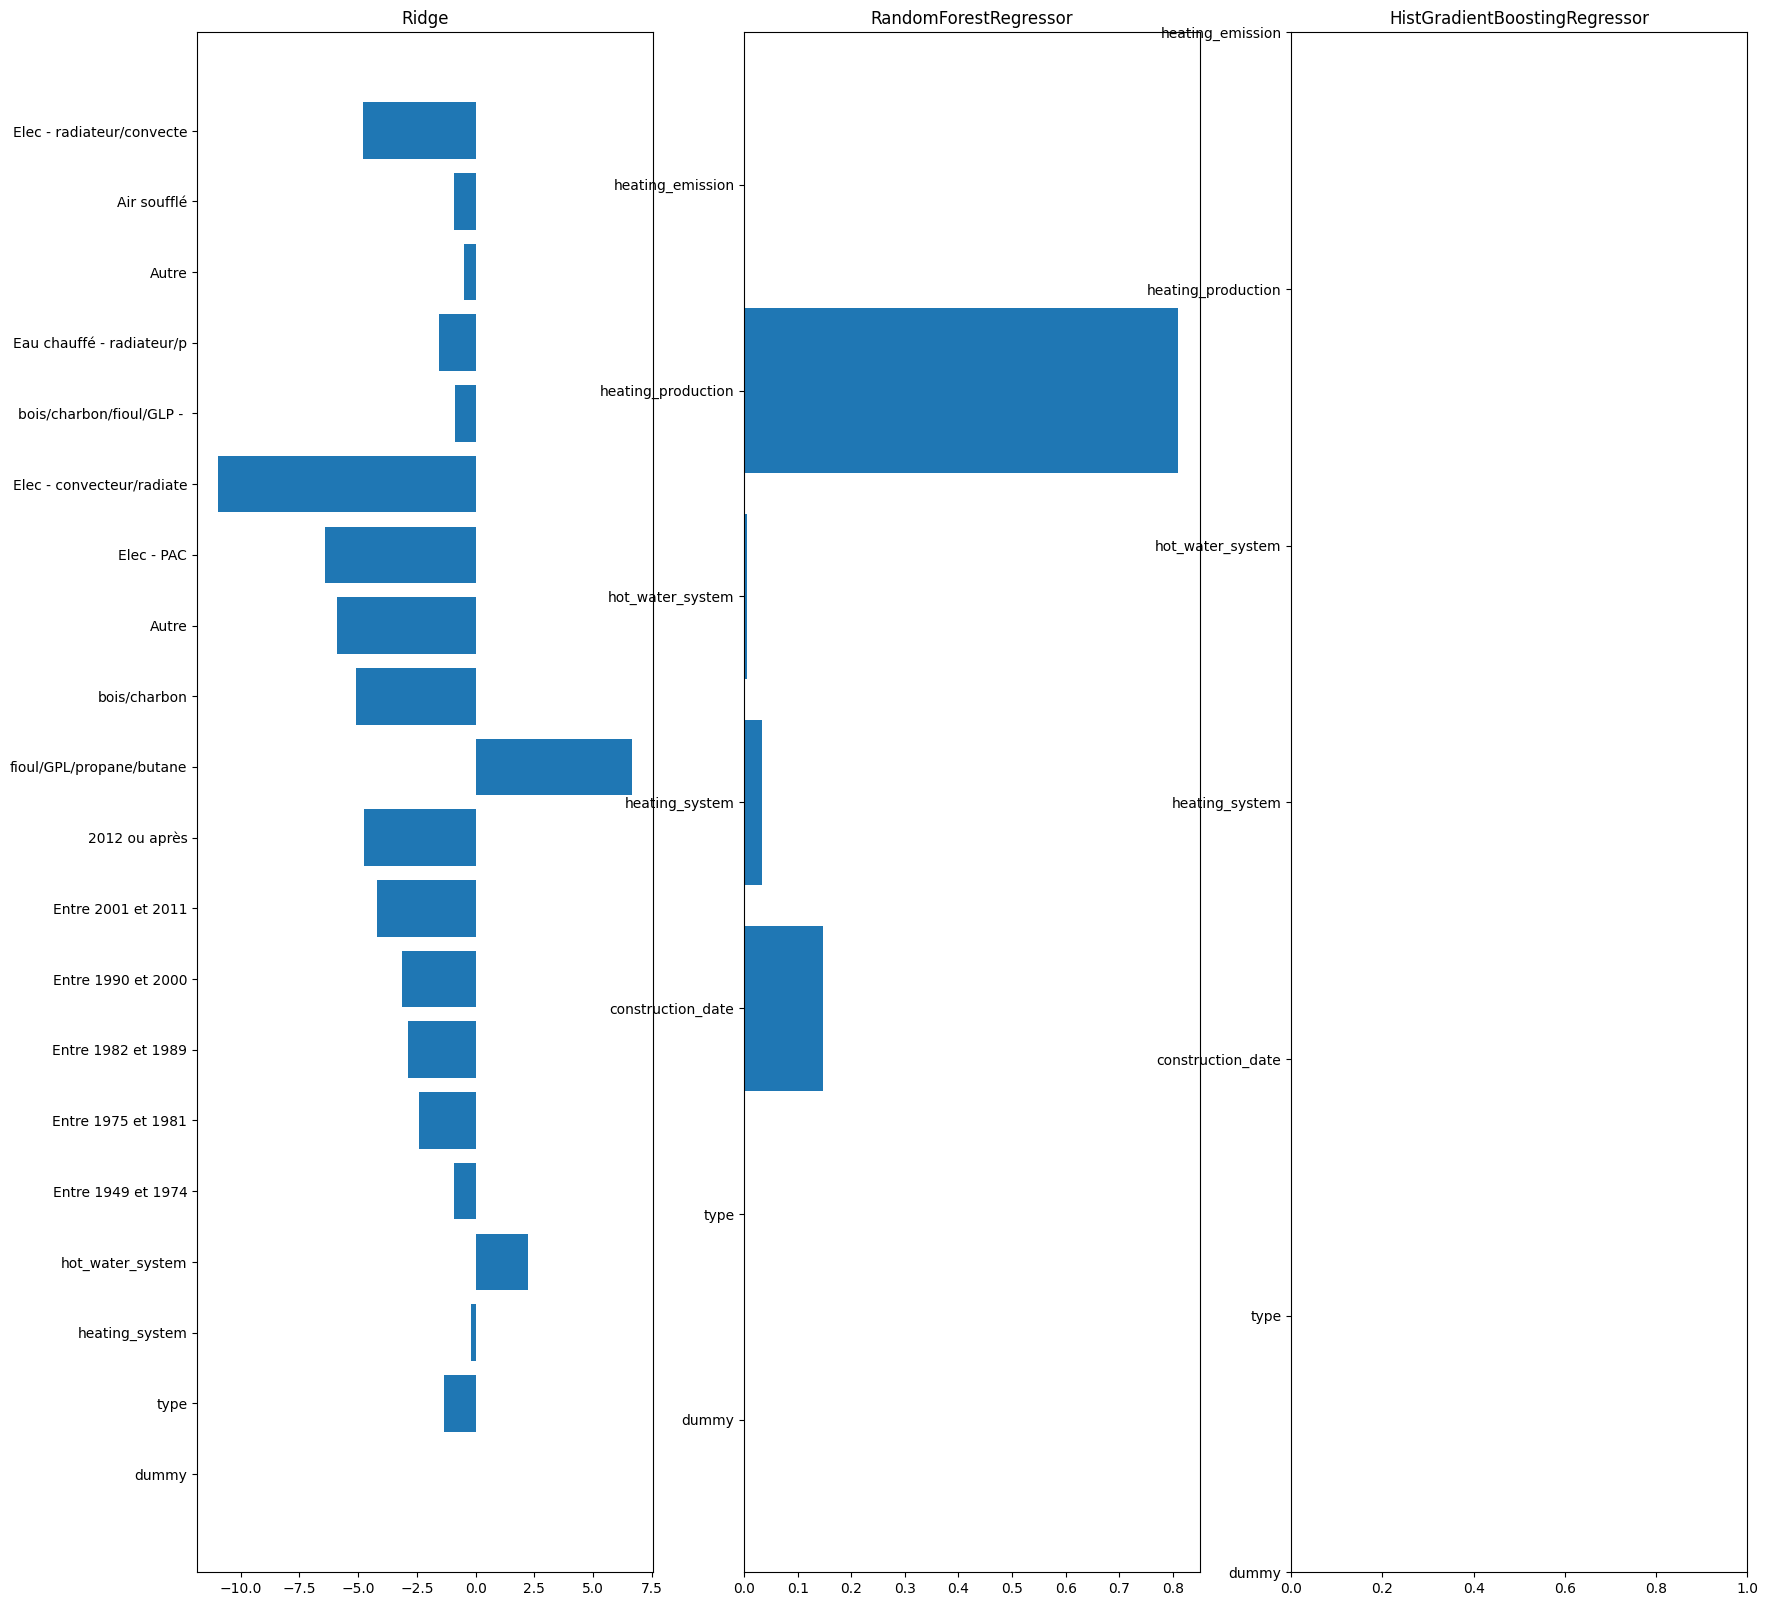

In [7]:
col_X_hot = [['construction_date', 'heating_production', 'heating_emission'],
            [],
            []]
col_y = ['GES_emission']
col_X_not_hot = [[col[0] for col in ges_training.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

categorical_features = [i for i in range(6)]

hyperparams_models = [
    {
        'alpha': randint(0,1000),
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'max_iter' : randint(100,300),
        'l2_regularization' : uniform(0,1),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'Ridge': Ridge,
    'RandomForestRegressor': RandomForestRegressor,
    'HistGradientBoostingRegressor' : HistGradientBoostingRegressor,
}
best_models_ges = all_in_one(ges_training, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4)

# categorical

In [6]:
# linear
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# HistGboost
from sklearn.ensemble import HistGradientBoostingClassifier

In [15]:
dpe_training_cat = dpe_training.withColumn(
    'DPE_consumption',
    F.when(F.col('DPE_consumption') <= 50, 0)
    .when((F.col('DPE_consumption') > 50) & (F.col('DPE_consumption') <= 90), 1)
    .when((F.col('DPE_consumption') > 90) & (F.col('DPE_consumption') <= 150), 2)
    .when((F.col('DPE_consumption') > 150) & (F.col('DPE_consumption') <= 230), 3)
    .when((F.col('DPE_consumption') > 230) & (F.col('DPE_consumption') <= 330), 4)
    .when((F.col('DPE_consumption') > 330) & (F.col('DPE_consumption') <= 450), 5)
    .otherwise(6)
)

ges_training_cat = ges_training.withColumn(
    'GES_emission',
    F.when(F.col('GES_emission') <= 5, 0)
    .when((F.col('GES_emission') > 5) & (F.col('GES_emission') <= 10), 1)
    .when((F.col('GES_emission') > 10) & (F.col('GES_emission') <= 20), 2)
    .when((F.col('GES_emission') > 20) & (F.col('GES_emission') <= 35), 3)
    .when((F.col('GES_emission') > 35) & (F.col('GES_emission') <= 55), 4)
    .when((F.col('GES_emission') > 55) & (F.col('GES_emission') <= 80), 5)
    .otherwise(6)
)

c:\Users\arocheteau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arocheteau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

0.3565500685871056 {'C': 993.9647961193003, 'class_weight': 'balanced', 'max_iter': 1000}
0.3722822359396433 {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 108}
0.473088134430727 {'l2_regularization': 0.8514486375512653, 'learning_rate': 0.03009975183614682, 'max_iter': 142}
not handled for this type of algorithm


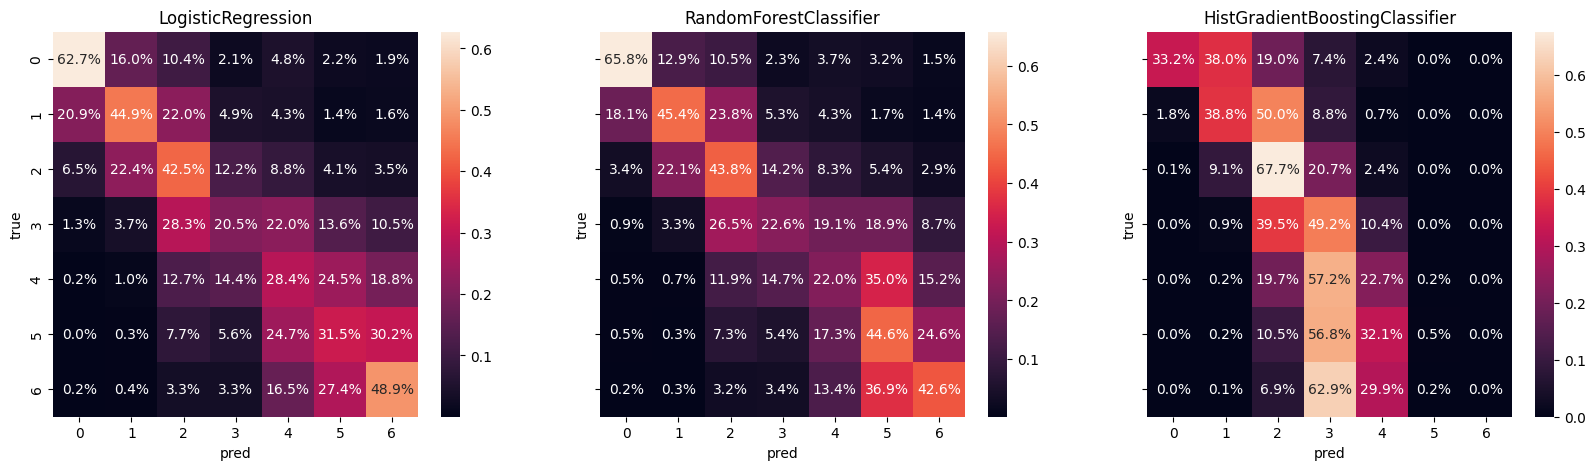

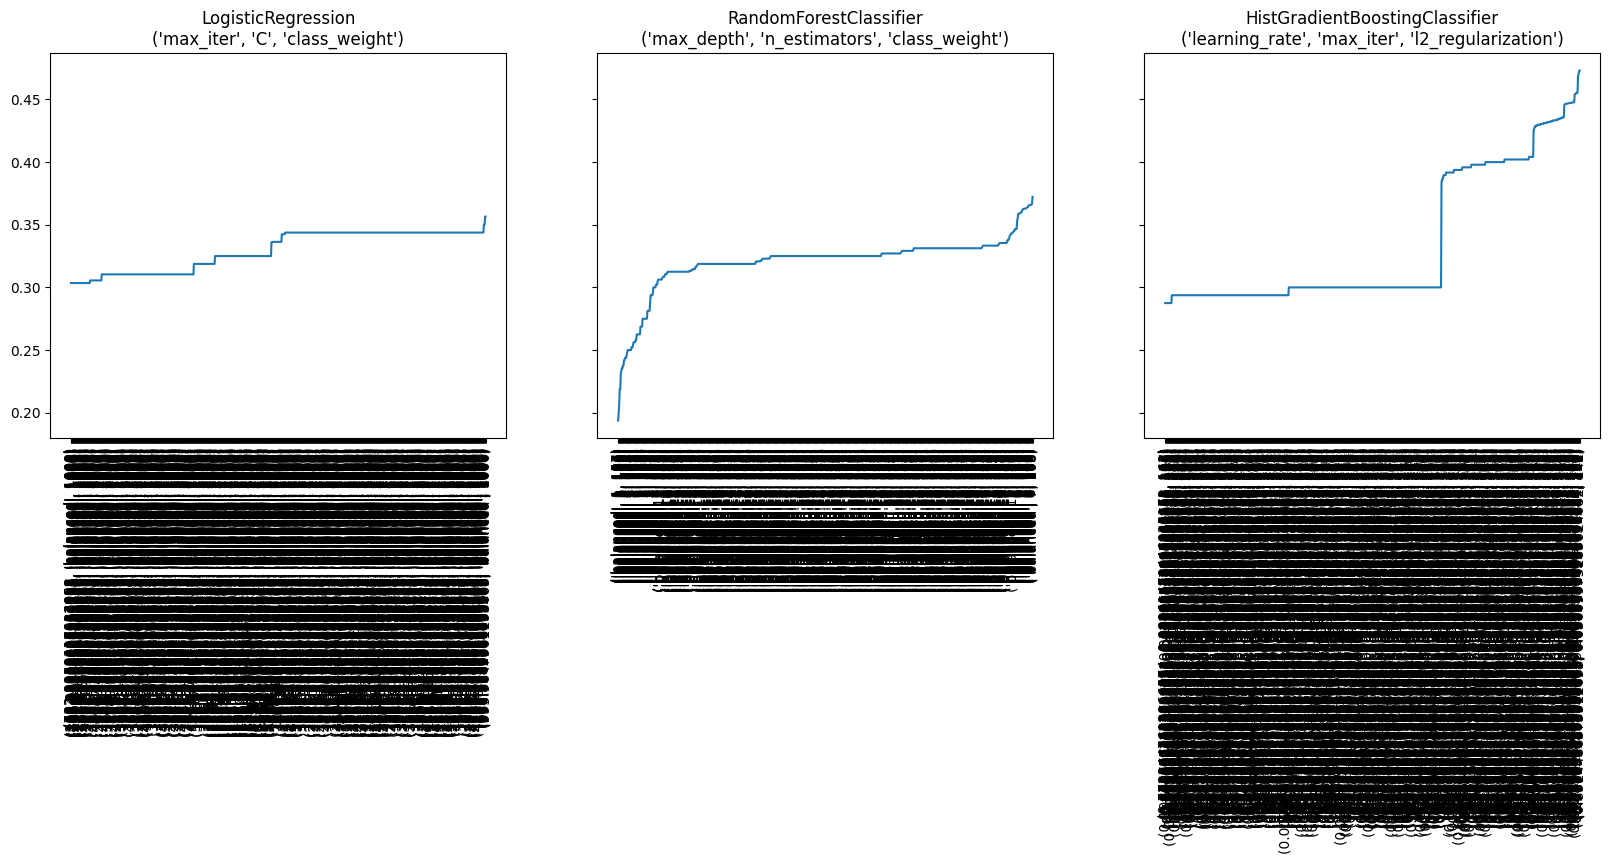

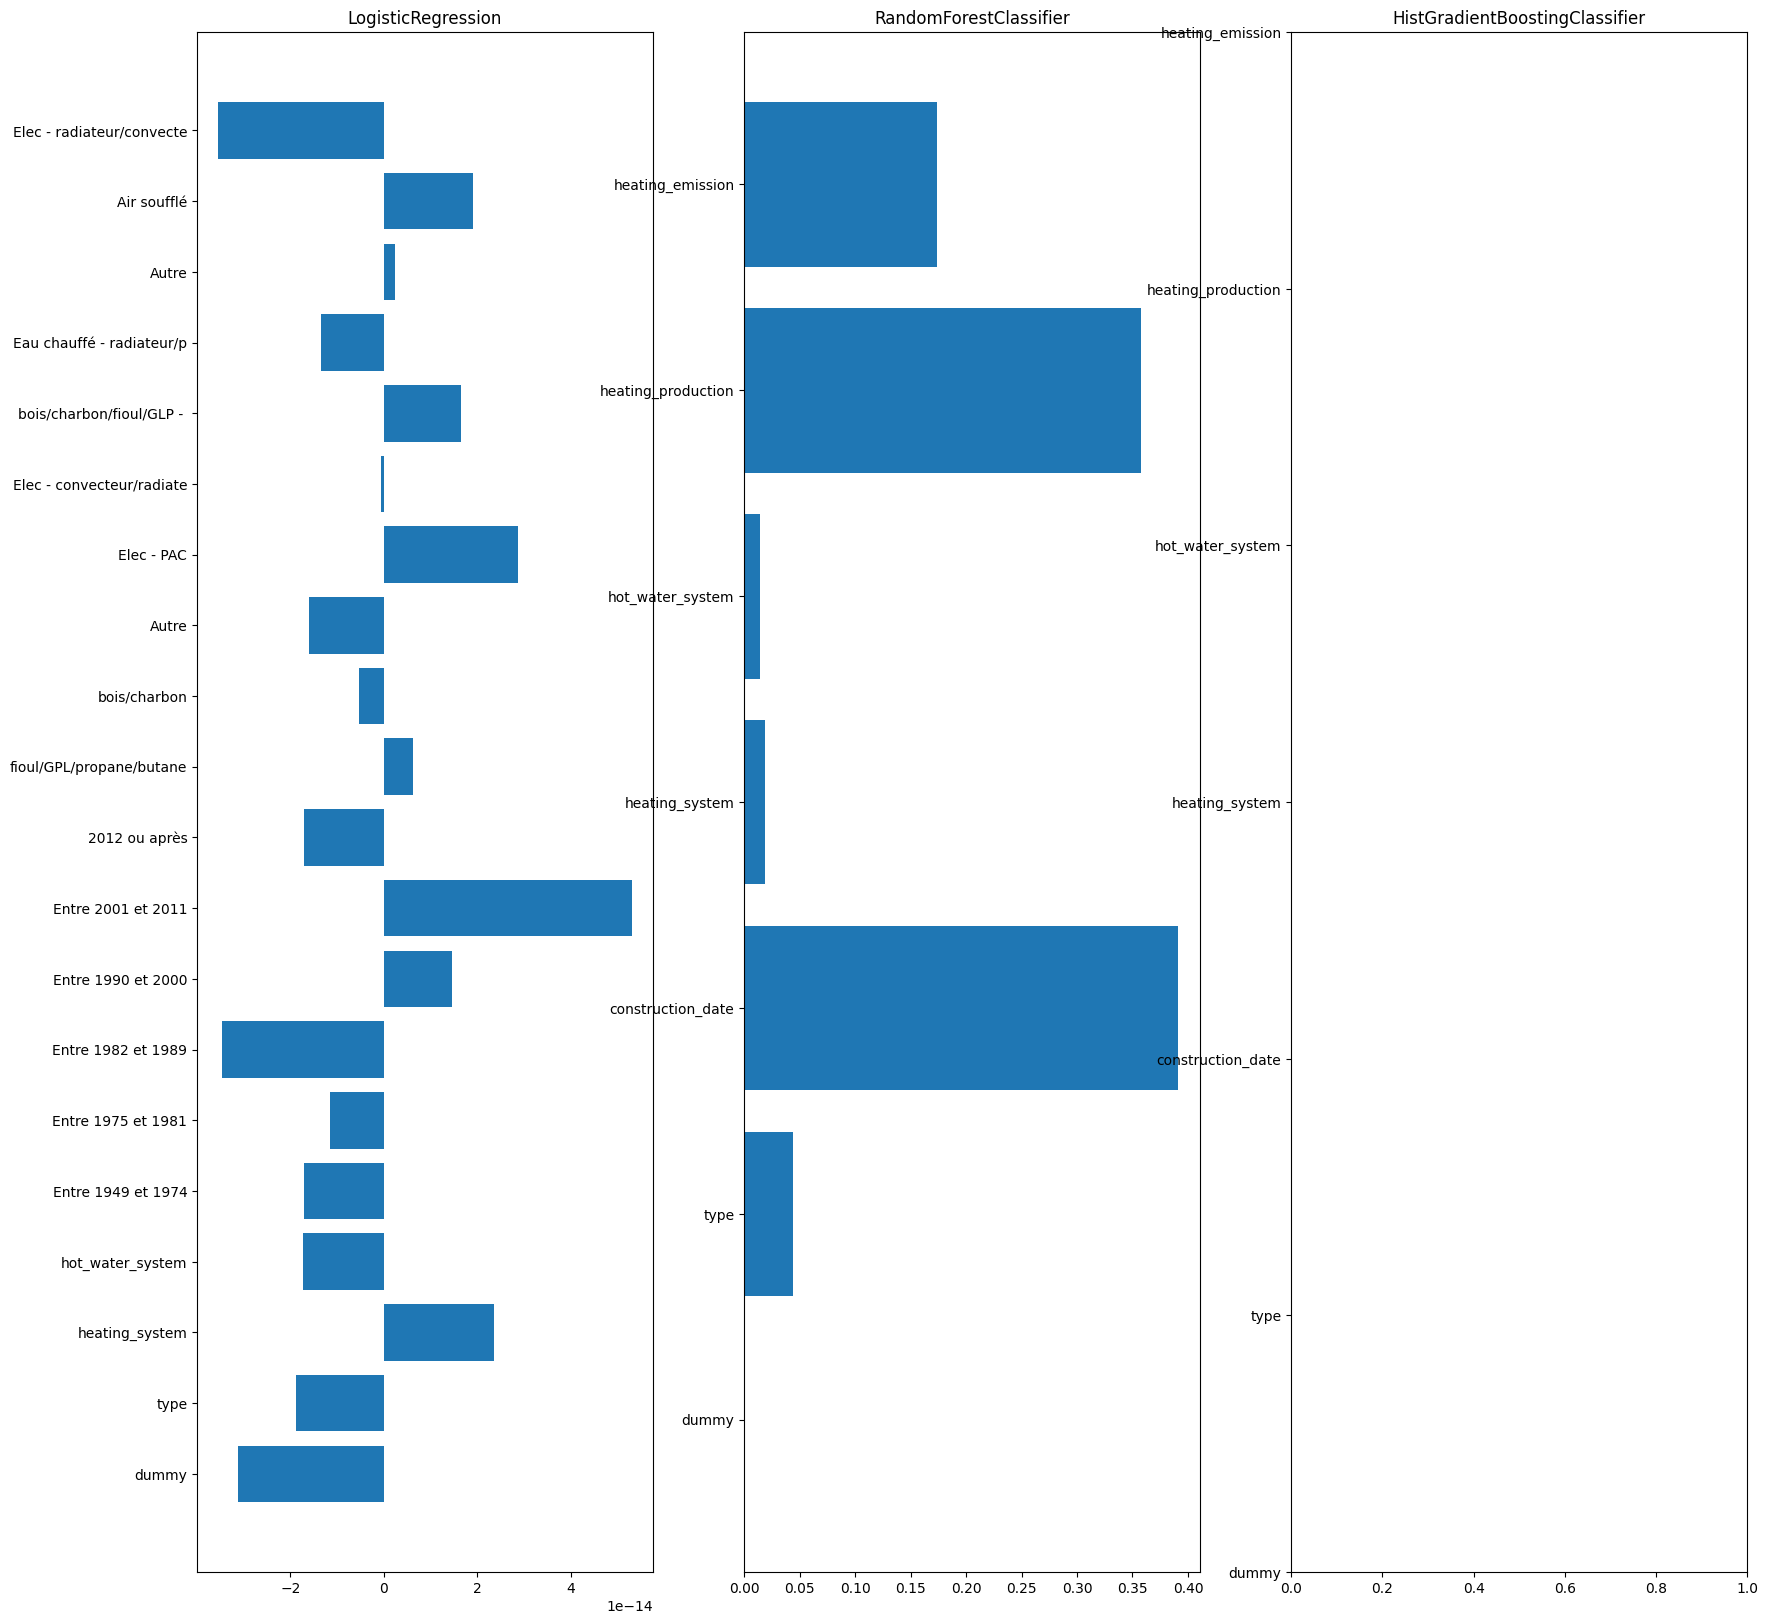

In [10]:
col_X_hot = [['construction_date', 'heating_production', 'heating_emission'],
            [],
            []]
col_y = ['DPE_consumption']
col_X_not_hot = [[col[0] for col in dpe_training_cat.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

categorical_features = [i for i in range(6)]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': uniform(1,1000),
        'class_weight': ['balanced'],
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'max_iter' : randint(100,300),#
        'l2_regularization' : uniform(0,1),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier,
    'HistGradientBoostingClassifier' : HistGradientBoostingClassifier,
}
best_models_ges = all_in_one(dpe_training_cat, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4, scoring='f1_micro')


c:\Users\arocheteau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arocheteau\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

0.44807098765432096 {'C': 64.37497047276774, 'class_weight': 'balanced', 'max_iter': 1000}
0.4603137860082304 {'class_weight': 'balanced', 'max_depth': 6, 'n_estimators': 103}
0.49356995884773663 {'l2_regularization': 0.9264494235897112, 'learning_rate': 0.24647896522538315, 'max_iter': 159}
not handled for this type of algorithm


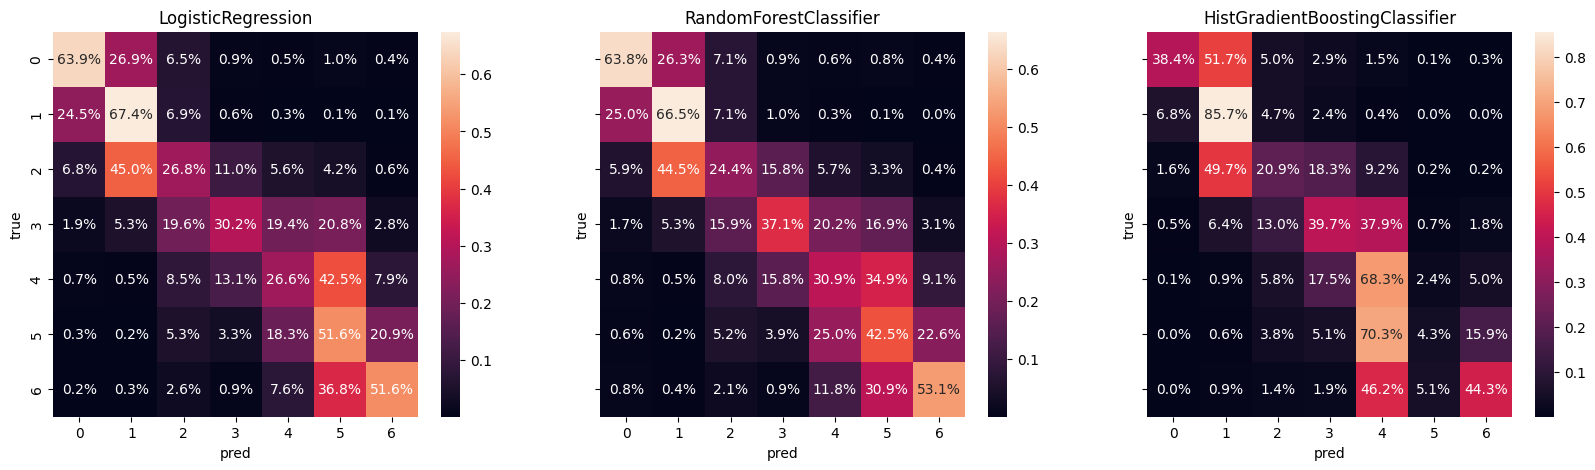

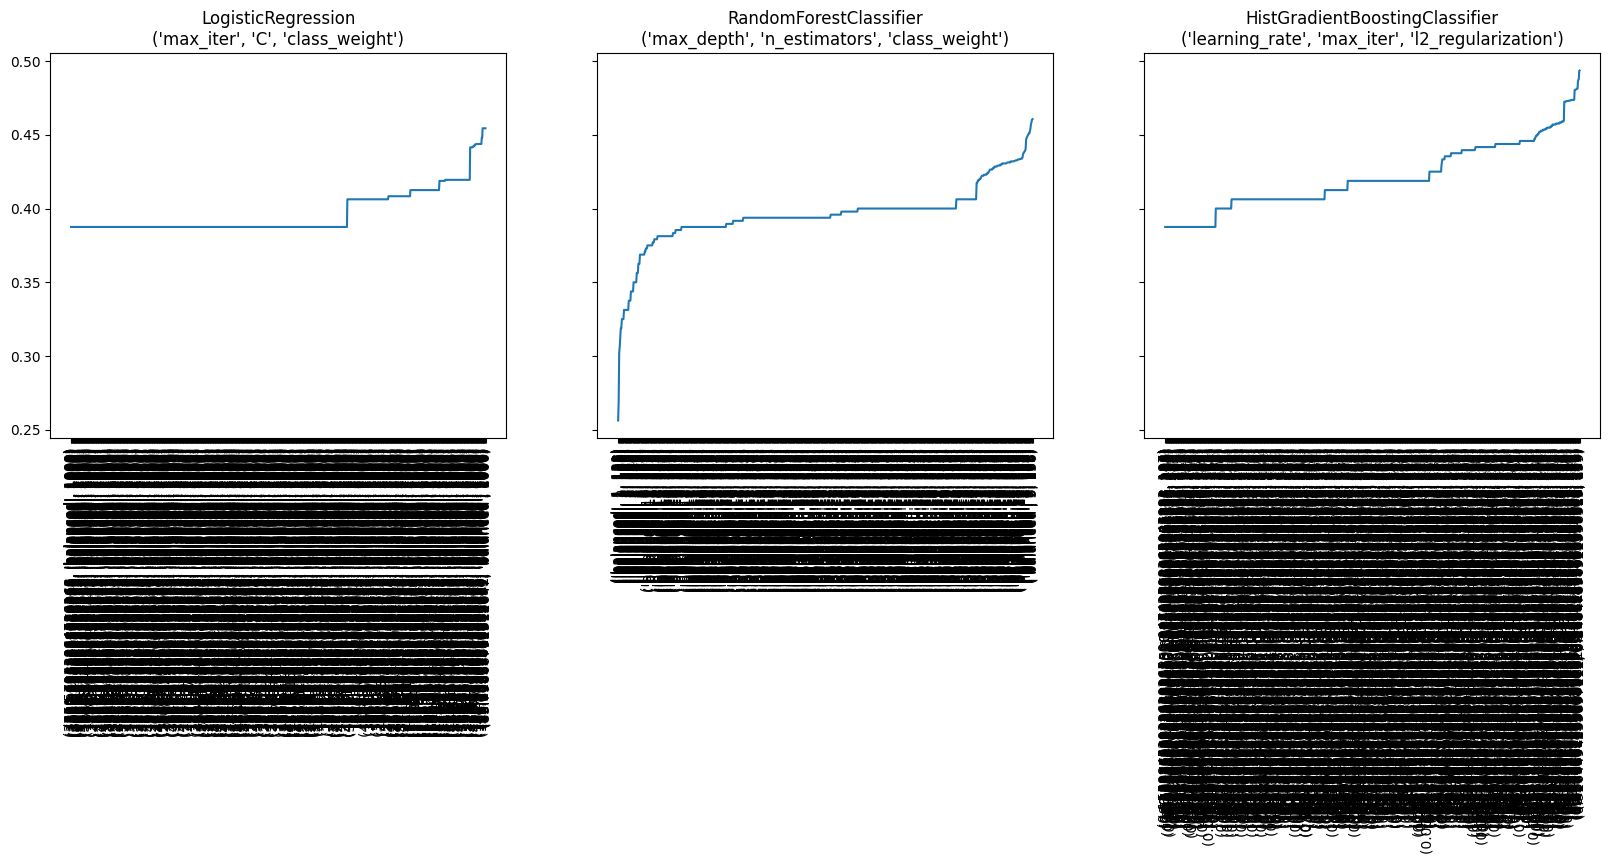

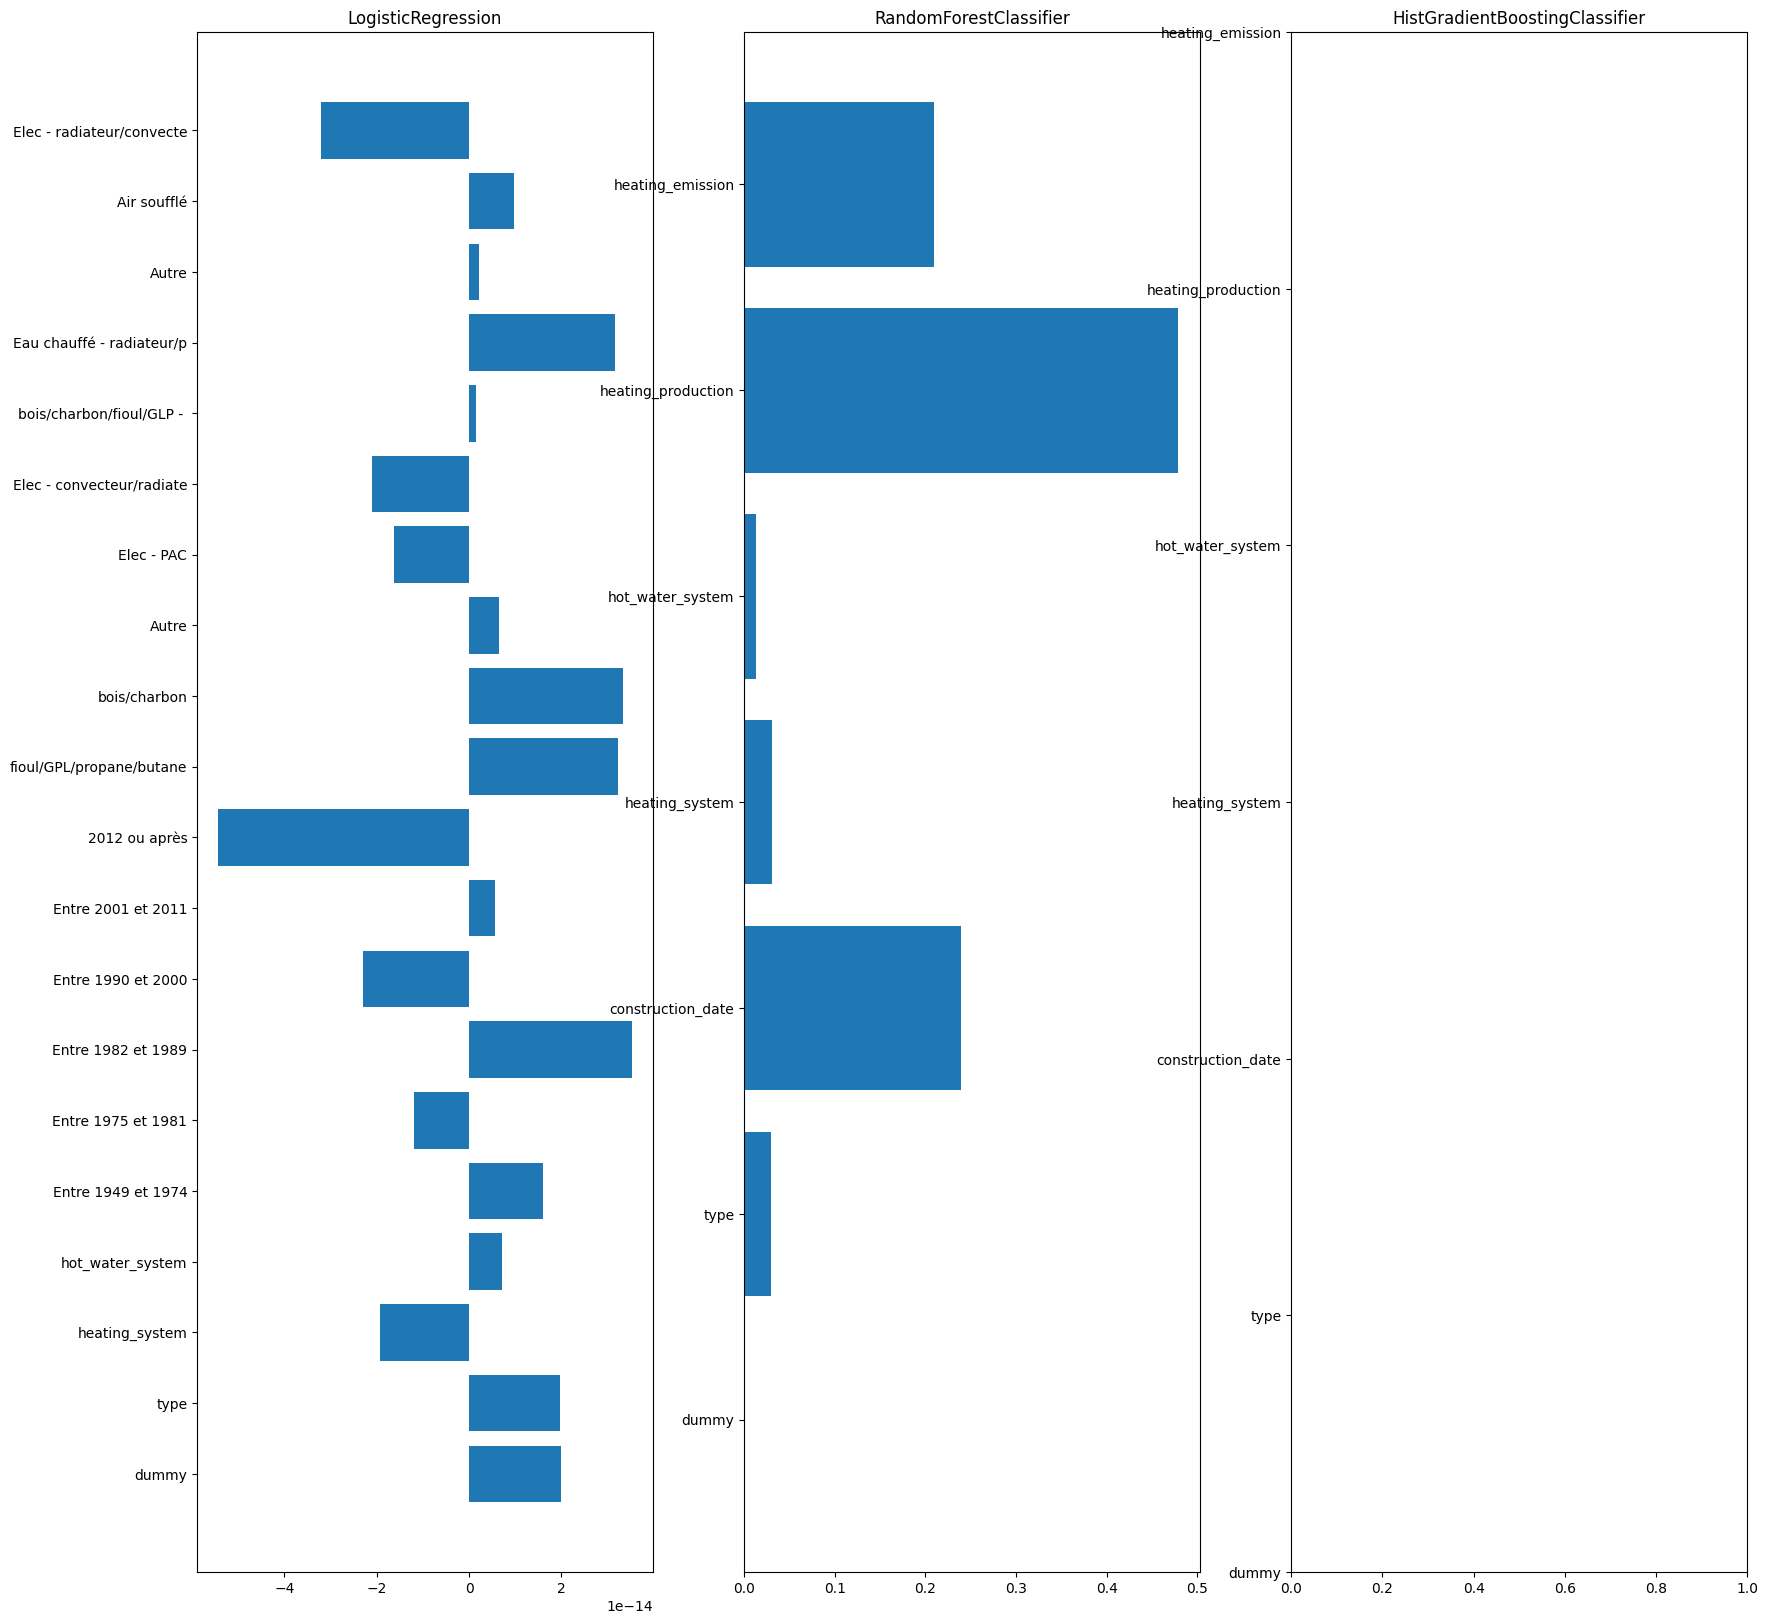

In [11]:
col_X_hot = [['construction_date', 'heating_production', 'heating_emission'],
            [],
            []]
col_y = ['GES_emission']
col_X_not_hot = [[col[0] for col in ges_training_cat.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

categorical_features = [i for i in range(6)]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': uniform(1,1000),
        'class_weight': ['balanced'],
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'max_depth': randint(1,20),
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'max_iter' : randint(100,300),
        'l2_regularization' : uniform(0,1),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier,
    'HistGradientBoostingClassifier' : HistGradientBoostingClassifier,
}
best_models_ges = all_in_one(ges_training_cat, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4, scoring='f1_micro')
